In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

sys.path.append('../')
from vis.utils import transform as tr

plt.rcParams.update({'figure.max_open_warning': 0})

(20000,)


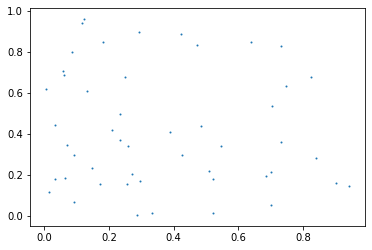

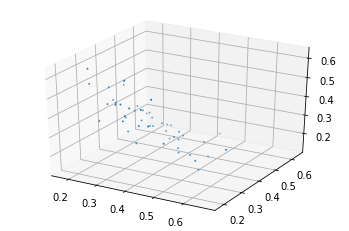

In [2]:
from vis.utils import transform as tr
from vis.utils import sampling as smp

np.random.seed(123456)

N = 20000
M = 3
n = 10 * M
X = smp.lhcl2(n=N, m=n)
F = np.zeros((N, M))
G = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        lb = np.floor(j * (n / M)).astype(np.int64)
        ub = np.floor((j+1) * (n / M)).astype(np.int64)
        a = 1.0 / np.floor(n / M)
        F[i,j] = a * np.sum(X[i, lb:ub])
        if j < M - 1: 
            # G[i,j] = F[i,-1] + 4 * F[i, j] - 1
            G[i,j] = 1 - F[i,-1] - 4 * F[i, j]
        else:
            if M == 2:
                minG = -1
            else:
                minG = float('inf')
                for i_ in range(M-1):
                    for j_ in range(M-1):
                        if i_ != j_:
                            s = F[i,i_] + F[i,j_]
                            if s <= minG:
                                minG = s
            # G[i,-1] = 2 * F[i,-1] + minG - 1
            G[i,-1] = 1 - 2 * F[i,-1] - minG
    
If = np.where(~(G.any(axis=1) <= 0))[0]
print(If.shape)
X = X[If]
F = F[If]
G = G[If]

Ip = tr.pfindices(F)
X = X[Ip]
F = F[Ip]
G = G[Ip]

fig = plt.figure()
ax = fig.gca()
ax.scatter(X[:,0], X[:,1], s=1)
plt.show() 

if F.shape[1] > 2:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(F[:,0], F[:,1], F[:,2], s=1)
    plt.show()
else:
    fig = plt.figure()
    ax = fig.gca()
    ax.scatter(F[:,0], F[:,1], s=1)
    plt.show()

(100,)


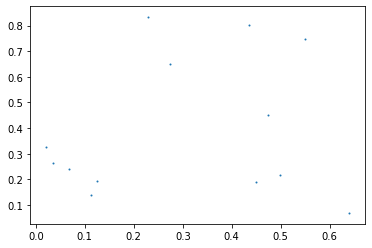

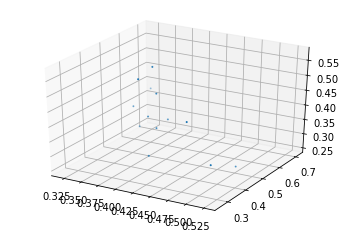

In [3]:
import autograd.numpy as anp

from pymoo.model.problem import Problem

class DTLZ8(Problem):

    def __init__(self, n_var=20, n_obj=2):
        
        # define lower and upper bounds -  1d array with length equal to number of variable
        xl = 0.0 * anp.ones(n_var)
        xu = 1.0 * anp.ones(n_var)
        
        super().__init__(n_var=n_var, n_obj=n_obj, n_constr=n_obj, xl=xl, xu=xu, evaluation_of="auto")

    def _evaluate(self, X, out, *args, **kwargs):
        N = X.shape[0]
        M = self.n_obj
        n = self.n_var
        F = np.zeros((N, M))
        G = np.zeros((N, M))
        for i in range(N):
            for j in range(M):
                lb = np.floor(j * (n / M)).astype(np.int64)
                ub = np.floor((j+1) * (n / M)).astype(np.int64)
                a = 1.0 / np.floor(n / M)
                F[i,j] = a * np.sum(X[i, lb:ub])
                if j < M - 1: 
                    G[i,j] = 1 - F[i,-1] - 4 * F[i, j]
                else:
                    if M == 2:
                        minG = -1
                    else:
                        minG = float('inf')
                        for i_ in range(M-1):
                            for j_ in range(M-1):
                                if i_ != j_:
                                    s = F[i,i_] + F[i,j_]
                                    if s <= minG:
                                        minG = s
                    G[i,-1] = 1 - 2 * F[i,-1] - minG

        out["F"] = F
        out["G"] = G

N = 100
M = 3
n = 10 * M
X = smp.lhcl2(n = N, m = n)
problem = DTLZ8(n_var = n, n_obj = M)
F, G = problem.evaluate(X, return_values_of=["F", "G"])

If = np.where(~(G.any(axis=1) < 0))[0]
print(If.shape)
X = X[If]
F = F[If]
G = G[If]

Ip = tr.pfindices(F)
X = X[Ip]
F = F[Ip]
G = G[Ip]

fig = plt.figure()
ax = fig.gca()
ax.scatter(X[:,0], X[:,1], s=1)
plt.show() 

if F.shape[1] > 2:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(F[:,0], F[:,1], F[:,2], s=1)
    plt.show()
else:
    fig = plt.figure()
    ax = fig.gca()
    ax.scatter(F[:,0], F[:,1], s=1)
    plt.show()

In [4]:
### from pymoo.algorithms.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
# ref_dirs = get_reference_directions("das-dennis", M, n_partitions = 50)
ref_dirs = get_reference_directions('uniform', M, n_points=3003, seed=1)
print(ref_dirs.shape)

# create the algorithm object
algorithm = NSGA3(pop_size=ref_dirs.shape[0] + 1,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(problem,
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

(3003, 3)


NameError: name 'NSGA3' is not defined